In [16]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
from typing import Any, List, Tuple, Dict, Optional
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
BATCH_SIZE = 128  # Размер батча
NUM_WORKERS = 4  # Количество процессов для параллельной выборки данных

# Гиперпараметры
LEARNING_RATE = 1e-3
NUM_EPOCHS = 200
PATIENCE = 30

DATA_ROOT = r"D:\Projects\Coding\ML\SamsungML\data\Coins\from_parsing\coins_split_50_aug_cat"  # абсолютный путь к обработанным данным

In [3]:
train_transforms = transforms.Compose([
    v2.Resize((224, 224)),
    v2.Grayscale(num_output_channels=3),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    v2.Resize((224, 224)),
    v2.Grayscale(num_output_channels=3),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_train_path = fr"{DATA_ROOT}\train"
data_valid_path = fr"{DATA_ROOT}\val"
data_test_path = fr"{DATA_ROOT}\test"

train_dataset = ImageFolder(data_train_path, transform=train_transforms)
val_dataset = ImageFolder(data_valid_path, transform=val_transforms)
test_dataset = ImageFolder(data_test_path, transform=val_transforms)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [4]:
def show_input(input_tensor: torch.Tensor, title: str = '') -> None:
    """
    Отображает входное изображение с нормализацией и заголовком.

    :param input_tensor: Тензор изображения.
    :param title: Заголовок изображения.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Преобразуем тензор в изображение
    image = input_tensor.cpu().permute(1, 2, 0).numpy()
    image = std * image + mean  # Денормализация изображения
    image = image.clip(0, 1)  # Обрезка значений изображения
    
    plt.imshow(image)
    plt.title(title)
    plt.show()
    plt.pause(0.001)

def visualize_batch(dataloader: DataLoader, class_names: List[str], num_images: int = 10) -> None:
    """
    Визуализирует изображения из батча.

    :param dataloader: DataLoader для данных.
    :param class_names: Список имен классов.
    :param num_images: Количество изображений для отображения.
    """
    X_batch, y_batch = next(iter(dataloader))
    
    for c, (x_item, y_item) in enumerate(zip(X_batch, y_batch)):
        show_input(x_item, title=class_names[y_item])
        if c >= num_images - 1:
            break

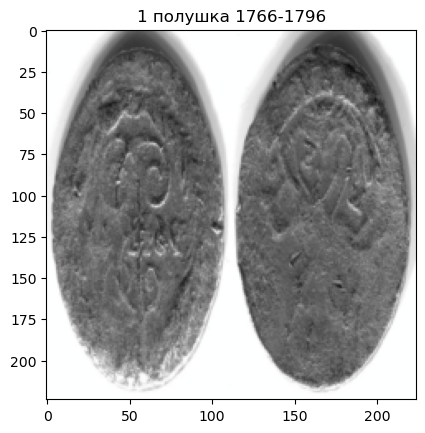

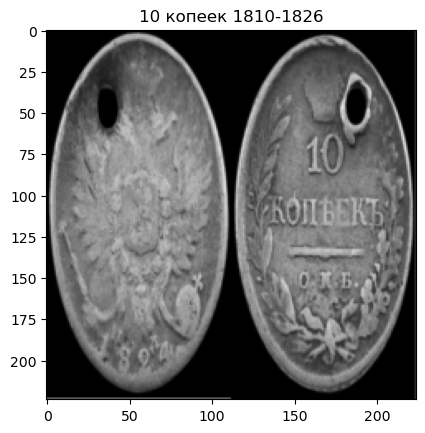

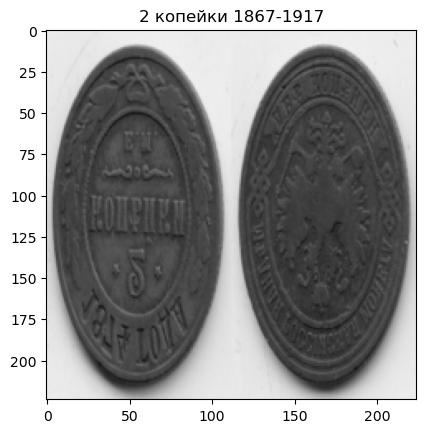

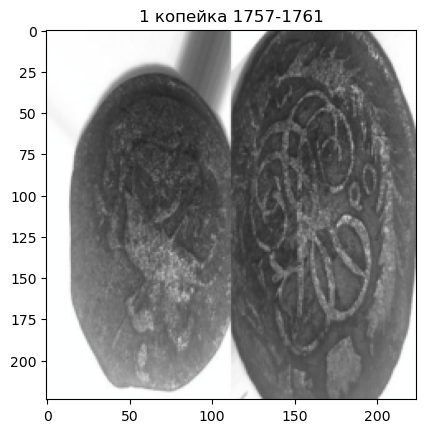

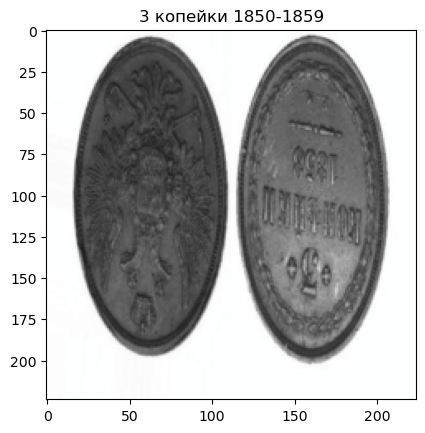

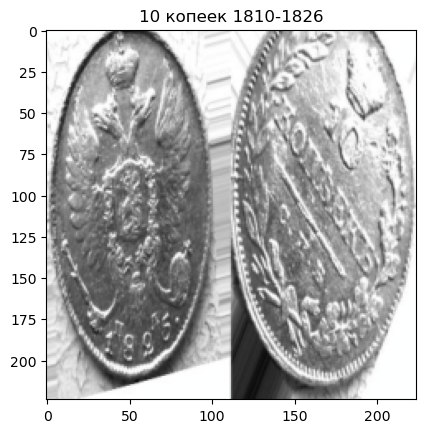

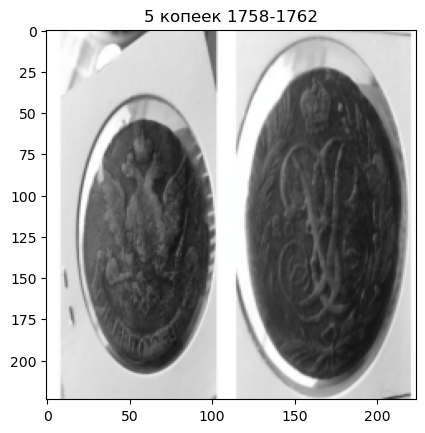

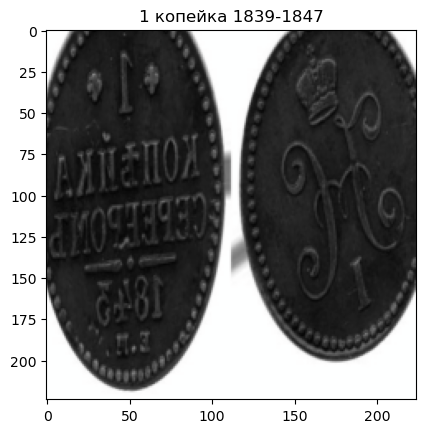

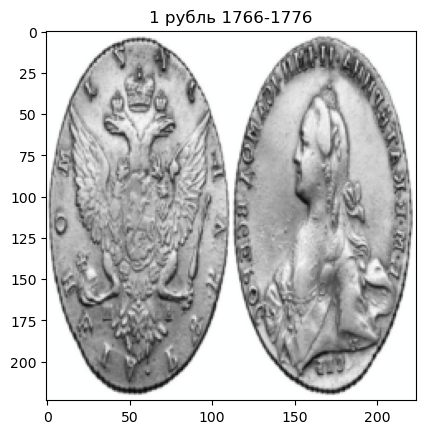

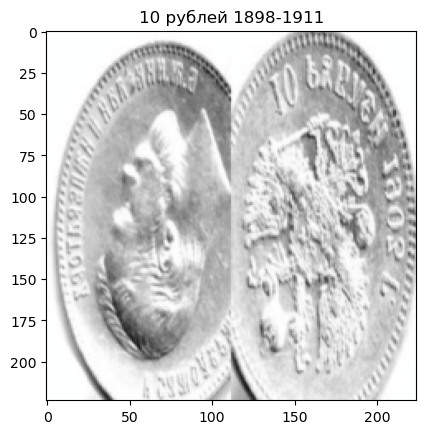

In [5]:
class_names = sorted(os.listdir(data_train_path))
visualize_batch(train_dataloader, class_names)

In [12]:
class Trainer:
    def __init__(self, model: torch.nn.Module, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler._LRScheduler):
        """
        Инициализирует класс Trainer.

        :param model: Модель для обучения.
        :param loss_fn: Функция потерь.
        :param optimizer: Оптимизатор.
        :param scheduler: Планировщик изменения скорости обучения.
        """
        self.history: Dict[str, list] = {'losses': [], 'val_losses': [], 'accuracy': [], 'val_accuracy': []}
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.start_time = time.time()

    def __train_step(self, train_loader: DataLoader, verbose: int) -> None:
        """
        Выполняет один шаг обучения.

        :param train_loader: DataLoader для тренировочных данных.
        :param verbose: Уровень детализации вывода.
        """
        self.model.train()
        train_loss = 0
        train_acc = 0
        batches = len(train_loader)

        for inputs, labels in tqdm(train_loader, desc="Training", leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
            preds = self.model(inputs)

            loss = self.loss_fn(preds, labels)
            preds_class = preds.argmax(dim=1)

            train_loss += loss.item()
            train_acc += (preds_class == labels).float().mean().cpu().numpy()

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

        train_loss /= batches
        train_acc /= batches
        self.history['losses'].append(train_loss)
        self.history['accuracy'].append(train_acc)

        if verbose:
            print(f"Training - loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")

    def __eval_step(self, val_loader: DataLoader, verbose: int) -> None:
        """
        Выполняет один шаг оценки.

        :param val_loader: DataLoader для валидационных данных.
        :param verbose: Уровень детализации вывода.
        """
        self.model.eval()
        val_loss = 0
        val_acc = 0
        batches = len(val_loader)

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=True):
                inputs, labels = inputs.to(device), labels.to(device)
                preds = self.model(inputs)

                loss = self.loss_fn(preds, labels)
                preds_class = preds.argmax(dim=1)

                val_loss += loss.item()
                val_acc += (preds_class == labels).float().mean().cpu().numpy()

        val_loss /= batches
        val_acc /= batches
        self.history['val_losses'].append(val_loss)
        self.history['val_accuracy'].append(val_acc)

        if verbose:
            print(f"Validation - loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

    def on_train_end(self) -> None:
        """
        Выводит время, затраченное на обучение.
        """
        duration = time.time() - self.start_time
        hours, rem = divmod(duration, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f'Training time: {int(hours)}h {int(minutes)}m {seconds:.2f}s', flush=True)

    def fit(self, train_loader: DataLoader, val_loader: DataLoader, epochs: int, verbose: int, patience: int) -> None:
        """
        Обучает модель.

        :param train_loader: DataLoader для тренировочных данных.
        :param val_loader: DataLoader для валидационных данных.
        :param epochs: Количество эпох.
        :param verbose: Уровень детализации вывода.
        :param patience: Патенс для ранней остановки.
        """
        best_loss = float('inf')
        best_model_state: Optional[Dict[str, Any]] = None
        current_patience = patience

        for epoch in range(epochs):
            if verbose:
                print(f"Epoch {epoch + 1}/{epochs}")
            self.__train_step(train_loader, verbose)
            self.__eval_step(val_loader, verbose)

            if self.history['val_losses'][-1] < best_loss:
                best_loss = self.history['val_losses'][-1]
                best_model_state = self.model.state_dict()
                current_patience = patience
            else:
                current_patience -= 1
                if current_patience == 0:
                    break

            self.scheduler.step()

        if best_model_state:
            self.model.load_state_dict(best_model_state)
        self.on_train_end()

In [13]:
# Загрузка предобученной модели
model = torchvision.models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.DEFAULT)

# Заморозка глубоких слоев модели (практика показала, что модель лучше обучается с нуля)
# for param in model.parameters():
#     param.requires_grad = False

# Переопределение последнего слоя модели
model.classifier[-1] = torch.nn.Sequential(
    torch.nn.BatchNorm1d(1280),
    torch.nn.Linear(1280, len(os.listdir(data_test_path))),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(0.5),
    torch.nn.Softmax(dim=1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.nn.DataParallel(model).to(device)

# Определение функций потерь, оптимизатора и планировщика
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [14]:
# Создание объекта тренера и обучение модели
trainer = Trainer(model, loss_fn, optimizer, scheduler)
trainer.fit(train_dataloader, val_dataloader, NUM_EPOCHS, verbose=1, patience=PATIENCE)

Epoch 1/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:42<00:00,  1.30s/it]


Training - loss: 4.2447, accuracy: 0.1631


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


Validation - loss: 4.2242, accuracy: 0.1933
Epoch 2/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:44<00:00,  1.32s/it]


Training - loss: 4.1606, accuracy: 0.2444


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


Validation - loss: 4.2328, accuracy: 0.1820
Epoch 3/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:42<00:00,  1.30s/it]


Training - loss: 4.1140, accuracy: 0.2914


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 4.1070, accuracy: 0.3106
Epoch 4/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:42<00:00,  1.30s/it]


Training - loss: 4.0789, accuracy: 0.3247


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:42<00:00,  1.17it/s]


Validation - loss: 4.0665, accuracy: 0.3563
Epoch 5/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:43<00:00,  1.30s/it]


Training - loss: 4.0475, accuracy: 0.3563


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


Validation - loss: 3.9555, accuracy: 0.4623
Epoch 6/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:42<00:00,  1.30s/it]


Training - loss: 4.0254, accuracy: 0.3785


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


Validation - loss: 3.9067, accuracy: 0.5178
Epoch 7/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:43<00:00,  1.31s/it]


Training - loss: 4.0076, accuracy: 0.3964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


Validation - loss: 3.8825, accuracy: 0.5417
Epoch 8/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:42<00:00,  1.30s/it]


Training - loss: 4.0052, accuracy: 0.3989


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]


Validation - loss: 3.8623, accuracy: 0.5636
Epoch 9/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9900, accuracy: 0.4135


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.8968, accuracy: 0.5305
Epoch 10/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9790, accuracy: 0.4246


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.8213, accuracy: 0.5973
Epoch 11/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9847, accuracy: 0.4187


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.8147, accuracy: 0.6027
Epoch 12/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9743, accuracy: 0.4301


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7995, accuracy: 0.6184
Epoch 13/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9722, accuracy: 0.4312


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.7766, accuracy: 0.6364
Epoch 14/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9693, accuracy: 0.4347


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7681, accuracy: 0.6511
Epoch 15/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9671, accuracy: 0.4363


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7974, accuracy: 0.6212
Epoch 16/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9597, accuracy: 0.4435


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7319, accuracy: 0.6822
Epoch 17/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9597, accuracy: 0.4436


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7556, accuracy: 0.6591
Epoch 18/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9572, accuracy: 0.4461


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.7819, accuracy: 0.6348
Epoch 19/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9506, accuracy: 0.4522


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.61it/s]


Validation - loss: 3.7556, accuracy: 0.6645
Epoch 20/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9532, accuracy: 0.4499


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7397, accuracy: 0.6748
Epoch 21/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9480, accuracy: 0.4551


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7373, accuracy: 0.6778
Epoch 22/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9457, accuracy: 0.4576


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.7053, accuracy: 0.7067
Epoch 23/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9542, accuracy: 0.4486


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7153, accuracy: 0.6969
Epoch 24/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9480, accuracy: 0.4551


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.7032, accuracy: 0.7086
Epoch 25/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9371, accuracy: 0.4659


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6920, accuracy: 0.7200
Epoch 26/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9469, accuracy: 0.4562


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7053, accuracy: 0.7102
Epoch 27/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9464, accuracy: 0.4566


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.7153, accuracy: 0.6955
Epoch 28/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9374, accuracy: 0.4656


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7441, accuracy: 0.6702
Epoch 29/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9388, accuracy: 0.4642


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


Validation - loss: 3.6843, accuracy: 0.7291
Epoch 30/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9365, accuracy: 0.4666


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6934, accuracy: 0.7214
Epoch 31/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9331, accuracy: 0.4698


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.7233, accuracy: 0.6884
Epoch 32/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Training - loss: 3.9317, accuracy: 0.4714


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6926, accuracy: 0.7189
Epoch 33/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9373, accuracy: 0.4654


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6895, accuracy: 0.7266
Epoch 34/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9315, accuracy: 0.4714


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


Validation - loss: 3.6726, accuracy: 0.7416
Epoch 35/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9316, accuracy: 0.4709


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6481, accuracy: 0.7659
Epoch 36/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9360, accuracy: 0.4669


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6593, accuracy: 0.7530
Epoch 37/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9384, accuracy: 0.4646


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6568, accuracy: 0.7534
Epoch 38/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9256, accuracy: 0.4773


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6412, accuracy: 0.7706
Epoch 39/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9292, accuracy: 0.4736


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6730, accuracy: 0.7416
Epoch 40/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9291, accuracy: 0.4734


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6703, accuracy: 0.7416
Epoch 41/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9316, accuracy: 0.4710


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6602, accuracy: 0.7491
Epoch 42/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9343, accuracy: 0.4688


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6618, accuracy: 0.7525
Epoch 43/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9260, accuracy: 0.4771


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6436, accuracy: 0.7683
Epoch 44/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9230, accuracy: 0.4799


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6533, accuracy: 0.7619
Epoch 45/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9329, accuracy: 0.4698


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6324, accuracy: 0.7788
Epoch 46/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:37<00:00,  1.26s/it]


Training - loss: 3.9238, accuracy: 0.4791


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6434, accuracy: 0.7691
Epoch 47/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9290, accuracy: 0.4738


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6504, accuracy: 0.7589
Epoch 48/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9294, accuracy: 0.4738


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6386, accuracy: 0.7747
Epoch 49/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9213, accuracy: 0.4818


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6183, accuracy: 0.7922
Epoch 50/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9278, accuracy: 0.4747


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6223, accuracy: 0.7869
Epoch 51/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:36<00:00,  1.25s/it]


Training - loss: 3.9230, accuracy: 0.4796


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6371, accuracy: 0.7744
Epoch 52/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9273, accuracy: 0.4758


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6406, accuracy: 0.7719
Epoch 53/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9237, accuracy: 0.4791


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6363, accuracy: 0.7730
Epoch 54/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9224, accuracy: 0.4800


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6206, accuracy: 0.7919
Epoch 55/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9179, accuracy: 0.4847


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6235, accuracy: 0.7873
Epoch 56/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9239, accuracy: 0.4788


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6323, accuracy: 0.7766
Epoch 57/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9267, accuracy: 0.4759


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6351, accuracy: 0.7775
Epoch 58/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9194, accuracy: 0.4834


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6320, accuracy: 0.7791
Epoch 59/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9342, accuracy: 0.4682


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6340, accuracy: 0.7753
Epoch 60/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:39<00:00,  1.28s/it]


Training - loss: 3.9227, accuracy: 0.4800


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6374, accuracy: 0.7709
Epoch 61/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9181, accuracy: 0.4845


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6214, accuracy: 0.7911
Epoch 62/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9198, accuracy: 0.4828


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6242, accuracy: 0.7866
Epoch 63/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9183, accuracy: 0.4844


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6170, accuracy: 0.7923
Epoch 64/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9171, accuracy: 0.4856


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6152, accuracy: 0.7950
Epoch 65/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:42<00:00,  1.30s/it]


Training - loss: 3.9107, accuracy: 0.4917


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


Validation - loss: 3.6187, accuracy: 0.7922
Epoch 66/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9205, accuracy: 0.4821


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6135, accuracy: 0.7972
Epoch 67/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9196, accuracy: 0.4831


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6201, accuracy: 0.7919
Epoch 68/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9142, accuracy: 0.4883


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6083, accuracy: 0.8020
Epoch 69/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9125, accuracy: 0.4901


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6178, accuracy: 0.7955
Epoch 70/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9127, accuracy: 0.4898


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6174, accuracy: 0.7936
Epoch 71/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9135, accuracy: 0.4891


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6069, accuracy: 0.8047
Epoch 72/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9103, accuracy: 0.4921


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5975, accuracy: 0.8116
Epoch 73/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9155, accuracy: 0.4868


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5956, accuracy: 0.8150
Epoch 74/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9164, accuracy: 0.4861


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


Validation - loss: 3.6070, accuracy: 0.8033
Epoch 75/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9145, accuracy: 0.4878


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6025, accuracy: 0.8092
Epoch 76/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9090, accuracy: 0.4934


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.6067, accuracy: 0.8033
Epoch 77/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9176, accuracy: 0.4848


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6056, accuracy: 0.8036
Epoch 78/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9113, accuracy: 0.4911


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.6062, accuracy: 0.8041
Epoch 79/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9132, accuracy: 0.4891


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5983, accuracy: 0.8148
Epoch 80/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9084, accuracy: 0.4939


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5911, accuracy: 0.8194
Epoch 81/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9120, accuracy: 0.4904


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5955, accuracy: 0.8161
Epoch 82/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9181, accuracy: 0.4841


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5919, accuracy: 0.8203
Epoch 83/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9130, accuracy: 0.4892


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s]


Validation - loss: 3.5901, accuracy: 0.8231
Epoch 84/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9060, accuracy: 0.4962


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5914, accuracy: 0.8194
Epoch 85/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9109, accuracy: 0.4916


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5948, accuracy: 0.8159
Epoch 86/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9102, accuracy: 0.4921


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5953, accuracy: 0.8145
Epoch 87/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9178, accuracy: 0.4846


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5917, accuracy: 0.8195
Epoch 88/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9168, accuracy: 0.4854


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5829, accuracy: 0.8269
Epoch 89/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9091, accuracy: 0.4931


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5865, accuracy: 0.8242
Epoch 90/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9075, accuracy: 0.4947


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5865, accuracy: 0.8241
Epoch 91/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9070, accuracy: 0.4952


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5881, accuracy: 0.8230
Epoch 92/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9140, accuracy: 0.4881


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.61it/s]


Validation - loss: 3.5836, accuracy: 0.8270
Epoch 93/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9104, accuracy: 0.4918


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.50it/s]


Validation - loss: 3.5823, accuracy: 0.8291
Epoch 94/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:42<00:00,  1.30s/it]


Training - loss: 3.9100, accuracy: 0.4921


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5843, accuracy: 0.8250
Epoch 95/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9101, accuracy: 0.4920


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5834, accuracy: 0.8284
Epoch 96/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:36<00:00,  1.25s/it]


Training - loss: 3.9067, accuracy: 0.4954


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5925, accuracy: 0.8164
Epoch 97/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:36<00:00,  1.25s/it]


Training - loss: 3.9082, accuracy: 0.4939


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5875, accuracy: 0.8250
Epoch 98/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:33<00:00,  1.23s/it]


Training - loss: 3.9107, accuracy: 0.4913


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5936, accuracy: 0.8195
Epoch 99/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:36<00:00,  1.25s/it]


Training - loss: 3.9126, accuracy: 0.4895


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5855, accuracy: 0.8259
Epoch 100/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:35<00:00,  1.25s/it]


Training - loss: 3.9006, accuracy: 0.5016


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5901, accuracy: 0.8234
Epoch 101/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:36<00:00,  1.25s/it]


Training - loss: 3.9037, accuracy: 0.4984


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5840, accuracy: 0.8286
Epoch 102/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:38<00:00,  1.27s/it]


Training - loss: 3.9011, accuracy: 0.5011


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5870, accuracy: 0.8286
Epoch 103/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:32<00:00,  1.22s/it]


Training - loss: 3.9011, accuracy: 0.5009


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5792, accuracy: 0.8344
Epoch 104/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:39<00:00,  1.28s/it]


Training - loss: 3.8956, accuracy: 0.5066


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5815, accuracy: 0.8303
Epoch 105/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Training - loss: 3.9024, accuracy: 0.4996


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5809, accuracy: 0.8292
Epoch 106/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:39<00:00,  1.28s/it]


Training - loss: 3.8995, accuracy: 0.5026


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5760, accuracy: 0.8375
Epoch 107/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Training - loss: 3.9050, accuracy: 0.4969


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5731, accuracy: 0.8384
Epoch 108/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.8952, accuracy: 0.5069


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5713, accuracy: 0.8408
Epoch 109/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Training - loss: 3.8978, accuracy: 0.5042


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5739, accuracy: 0.8395
Epoch 110/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Training - loss: 3.8940, accuracy: 0.5080


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5751, accuracy: 0.8378
Epoch 111/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9030, accuracy: 0.4989


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5740, accuracy: 0.8402
Epoch 112/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:37<00:00,  1.26s/it]


Training - loss: 3.9045, accuracy: 0.4974


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5736, accuracy: 0.8406
Epoch 113/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Training - loss: 3.9031, accuracy: 0.4988


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5748, accuracy: 0.8397
Epoch 114/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.8994, accuracy: 0.5026


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5753, accuracy: 0.8389
Epoch 115/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Training - loss: 3.9101, accuracy: 0.4918


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5726, accuracy: 0.8442
Epoch 116/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9070, accuracy: 0.4949


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5712, accuracy: 0.8422
Epoch 117/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:34<00:00,  1.24s/it]


Training - loss: 3.8995, accuracy: 0.5023


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5714, accuracy: 0.8434
Epoch 118/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9033, accuracy: 0.4986


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5729, accuracy: 0.8423
Epoch 119/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9072, accuracy: 0.4946


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5733, accuracy: 0.8428
Epoch 120/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.8976, accuracy: 0.5042


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5732, accuracy: 0.8442
Epoch 121/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.8954, accuracy: 0.5065


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5740, accuracy: 0.8427
Epoch 122/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9020, accuracy: 0.4998


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5733, accuracy: 0.8416
Epoch 123/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9011, accuracy: 0.5006


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5704, accuracy: 0.8477
Epoch 124/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9012, accuracy: 0.5005


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5712, accuracy: 0.8450
Epoch 125/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9023, accuracy: 0.4994


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5724, accuracy: 0.8445
Epoch 126/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9077, accuracy: 0.4940


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5734, accuracy: 0.8442
Epoch 127/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9017, accuracy: 0.4999


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5737, accuracy: 0.8438
Epoch 128/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9021, accuracy: 0.4996


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5732, accuracy: 0.8434
Epoch 129/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Training - loss: 3.9020, accuracy: 0.4996


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5731, accuracy: 0.8464
Epoch 130/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9039, accuracy: 0.4977


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5738, accuracy: 0.8464
Epoch 131/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.28s/it]


Training - loss: 3.9052, accuracy: 0.4963


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5759, accuracy: 0.8438
Epoch 132/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.8985, accuracy: 0.5031


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5753, accuracy: 0.8444
Epoch 133/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.8956, accuracy: 0.5059


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5756, accuracy: 0.8444
Epoch 134/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.8999, accuracy: 0.5016


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5761, accuracy: 0.8456
Epoch 135/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9016, accuracy: 0.4998


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5769, accuracy: 0.8464
Epoch 136/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:35<00:00,  1.24s/it]


Training - loss: 3.8988, accuracy: 0.5026


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5792, accuracy: 0.8431
Epoch 137/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9023, accuracy: 0.4990


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5806, accuracy: 0.8419
Epoch 138/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9032, accuracy: 0.4981


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5800, accuracy: 0.8453
Epoch 139/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9006, accuracy: 0.5008


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5804, accuracy: 0.8428
Epoch 140/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9005, accuracy: 0.5008


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5808, accuracy: 0.8434
Epoch 141/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9112, accuracy: 0.4901


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5821, accuracy: 0.8439
Epoch 142/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.8982, accuracy: 0.5031


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.61it/s]


Validation - loss: 3.5835, accuracy: 0.8442
Epoch 143/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9020, accuracy: 0.4993


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5829, accuracy: 0.8459
Epoch 144/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.8968, accuracy: 0.5044


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5832, accuracy: 0.8441
Epoch 145/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.8949, accuracy: 0.5062


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5845, accuracy: 0.8436
Epoch 146/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9041, accuracy: 0.4970


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5858, accuracy: 0.8427
Epoch 147/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9036, accuracy: 0.4974


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5871, accuracy: 0.8420
Epoch 148/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.9045, accuracy: 0.4964


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


Validation - loss: 3.5871, accuracy: 0.8438
Epoch 149/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:44<00:00,  1.31s/it]


Training - loss: 3.9004, accuracy: 0.5006


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5878, accuracy: 0.8427
Epoch 150/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9052, accuracy: 0.4957


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5883, accuracy: 0.8447
Epoch 151/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:40<00:00,  1.29s/it]


Training - loss: 3.8955, accuracy: 0.5054


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s]


Validation - loss: 3.5898, accuracy: 0.8430
Epoch 152/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.29s/it]


Training - loss: 3.9059, accuracy: 0.4948


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


Validation - loss: 3.5891, accuracy: 0.8450
Epoch 153/200


Training: 100%|██████████████████████████████████████████████████████████████████████| 125/125 [02:41<00:00,  1.30s/it]


Training - loss: 3.9020, accuracy: 0.4988


Validation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.39it/s]

Validation - loss: 3.5896, accuracy: 0.8445
Training time: 8h 10m 7.40s


In [17]:
def evaluate_model(model: torch.nn.Module, dataloader: DataLoader, device: torch.device) -> Tuple[Dict[str, float], List[int], List[int]]:
    """
    Оценивает модель на заданном датасете и возвращает метрики, истинные и предсказанные метки.

    :param model: Модель для оценки.
    :param dataloader: DataLoader для тестового датасета.
    :param device: Устройство для вычислений (CPU или GPU).
    :return: Словарь с метриками, список истинных меток, список предсказанных меток.
    """
    model.to(device)
    model.eval()
    
    all_labels: List[int] = []
    all_preds: List[int] = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    metrics: Dict[str, float] = {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds, average='macro'),
        'Recall': recall_score(all_labels, all_preds, average='macro'),
        'F1_score': f1_score(all_labels, all_preds, average='macro')
    }
    
    return metrics, all_labels, all_preds

In [18]:
def tr_plot(tr_data, start_epoch: int) -> None:
    """
    Строит графики точности и потерь для тренировочных и валидационных данных.

    :param tr_data: Класс с историей обучения.
    :param start_epoch: Начальный номер эпохи.
    """
    tr_acc = tr_data.history['accuracy']
    tr_loss = tr_data.history['losses']
    val_acc = tr_data.history['val_accuracy']
    val_loss = tr_data.history['val_losses']
    
    epoch_count = len(tr_acc) + start_epoch
    epochs = list(range(start_epoch + 1, epoch_count + 1))

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
    plt.style.use('fivethirtyeight')
    
    sc_label = f'best epoch = {index_loss + 1 + start_epoch}'
    vc_label = f'best epoch = {index_acc + 1 + start_epoch}'
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    axes[0].plot(epochs, tr_loss, 'r', label='Training Loss')
    axes[0].plot(epochs, val_loss, 'g', label='Validation Loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot(epochs, tr_acc, 'r', label='Training Accuracy')
    axes[1].plot(epochs, val_acc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

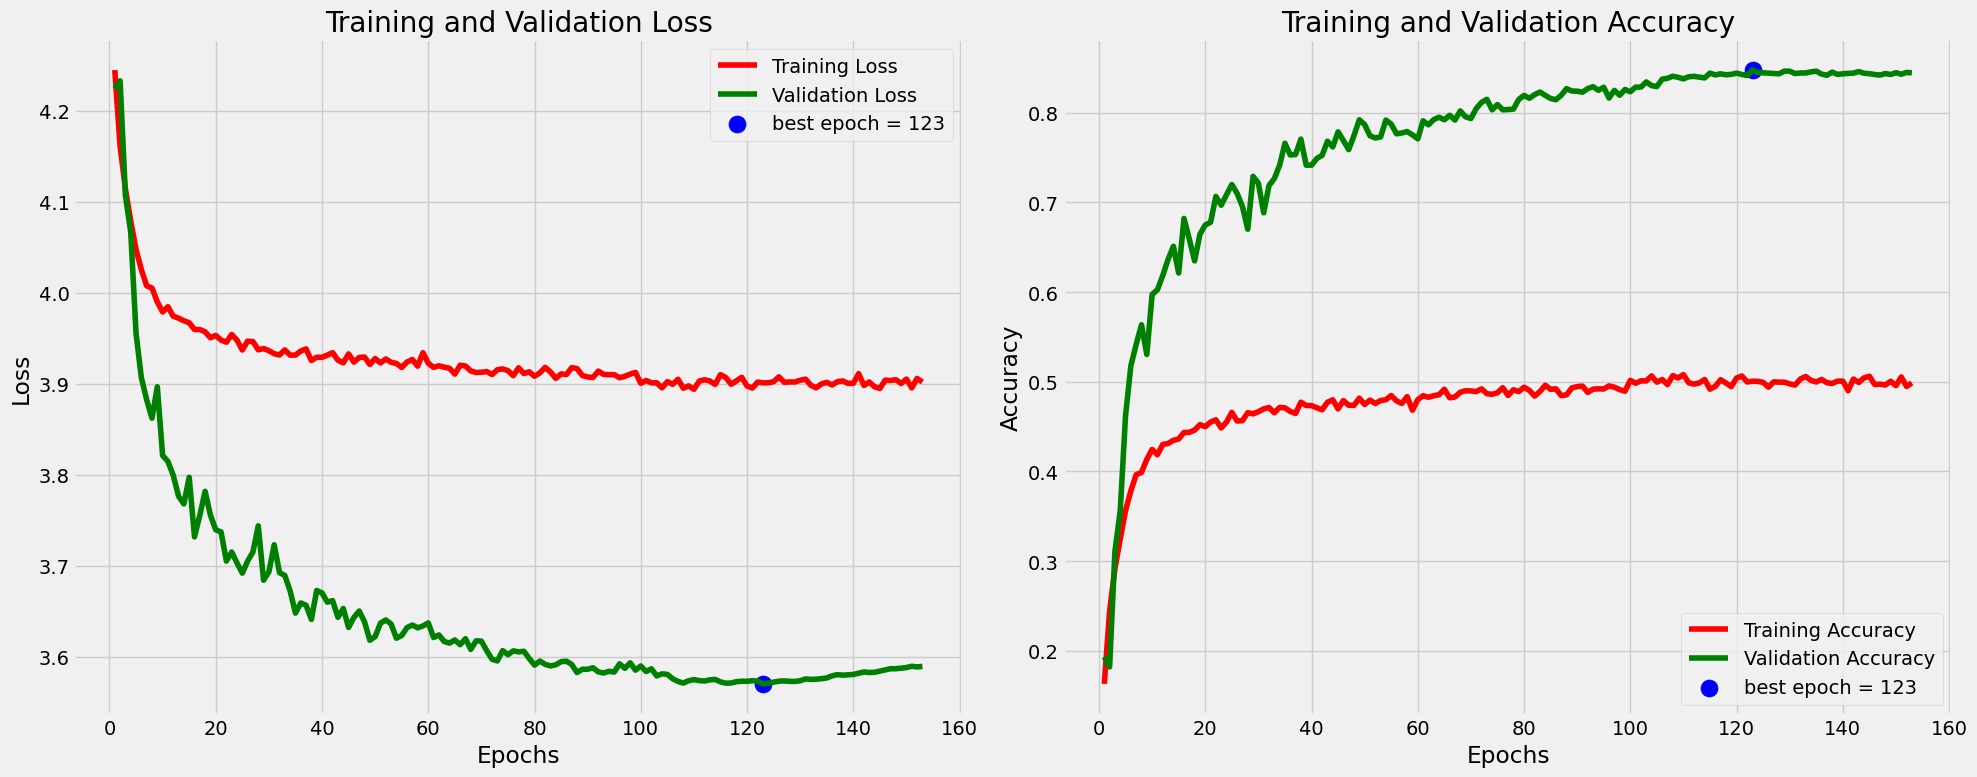

In [19]:
tr_plot(trainer, 0)

In [20]:
metrics, all_labels, all_preds = evaluate_model(model, test_dataloader, device)

In [21]:
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.9049
Precision: 0.9018
Recall: 0.8939
F1_score: 0.8908


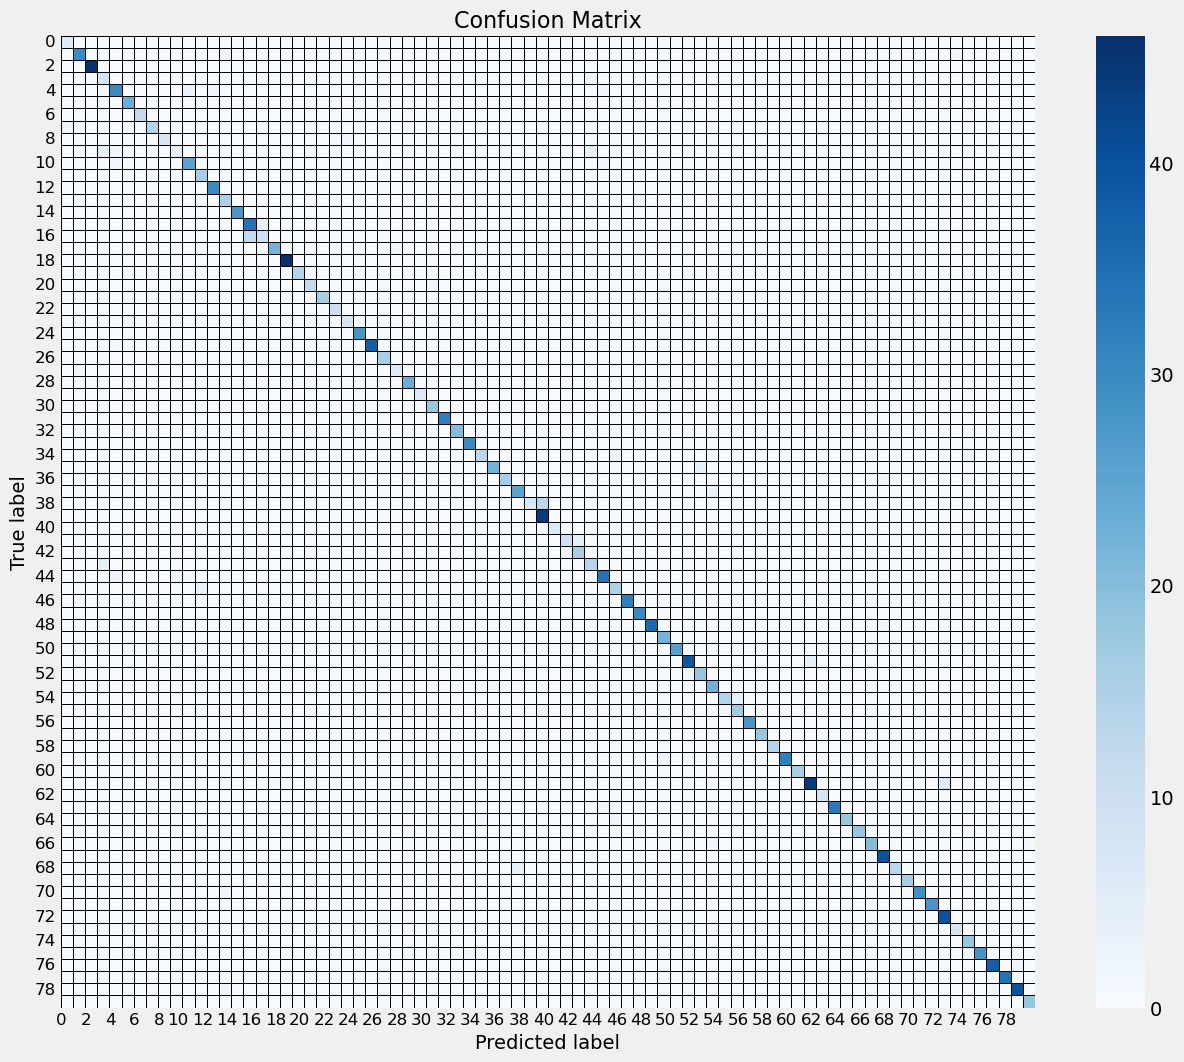

In [22]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14, 12))
ax = sns.heatmap(cm, fmt='d', cmap='Blues', cbar=True, linewidths=.5, linecolor='black')

ax.set_xlabel('Predicted label', fontsize=14)
ax.set_ylabel('True label', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
plt.show()

In [23]:
# Сохранение весов и модели
# model_path = r"D:\Projects\Coding\ML\SamsungML\SamsungProject\models"
# torch.save(trainer.model.state_dict(), os.path.join(nodel_path, "model_weights"))
# torch.save(trainer.model, os.path.join(nodel_path, os.path.join(nodel_path, "model")))